In [1]:
import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [2]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [13]:
len(sub_ids)

62

In [3]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0


In [4]:
# get the reference images to know the shape of the data
N_learning = image.load_img(subjects[0].img.get('learning1')).shape[-1]
N_test = image.load_img(subjects[0].img.get('test')).shape[-1]

In [5]:
all_volumes = np.zeros((len(subjects), 3))
all_volumes[:, :2] = N_learning
all_volumes[:, 2] = N_test

In [6]:
valid_volumes = np.zeros((len(subjects), 3))

for i, sub in enumerate(subjects):
    for j, run in enumerate(sub.runs):
        N_block = all_volumes[i,j]
        img_path = sub.img.get(run)
        _, sample_mask  = load_confounds(img_path,
                                         strategy=('motion','high_pass','wm_csf',
                                                   'scrub'),
                                         scrub=0,
                                         fd_threshold=.5,
                                         std_dvars_threshold=2.5) # type: ignore
        valid_volumes[i,j] = len(sample_mask) if sample_mask is not None else N_block

In [7]:
scrubbed_volumes = (all_volumes - valid_volumes)/all_volumes

In [8]:
scrubbed_volumes.mean(axis=0)

array([0.05001514, 0.06928669, 0.07145188])

In [9]:
scrubbed_volumes.std(axis=0)

array([0.04276698, 0.05471783, 0.05322452])

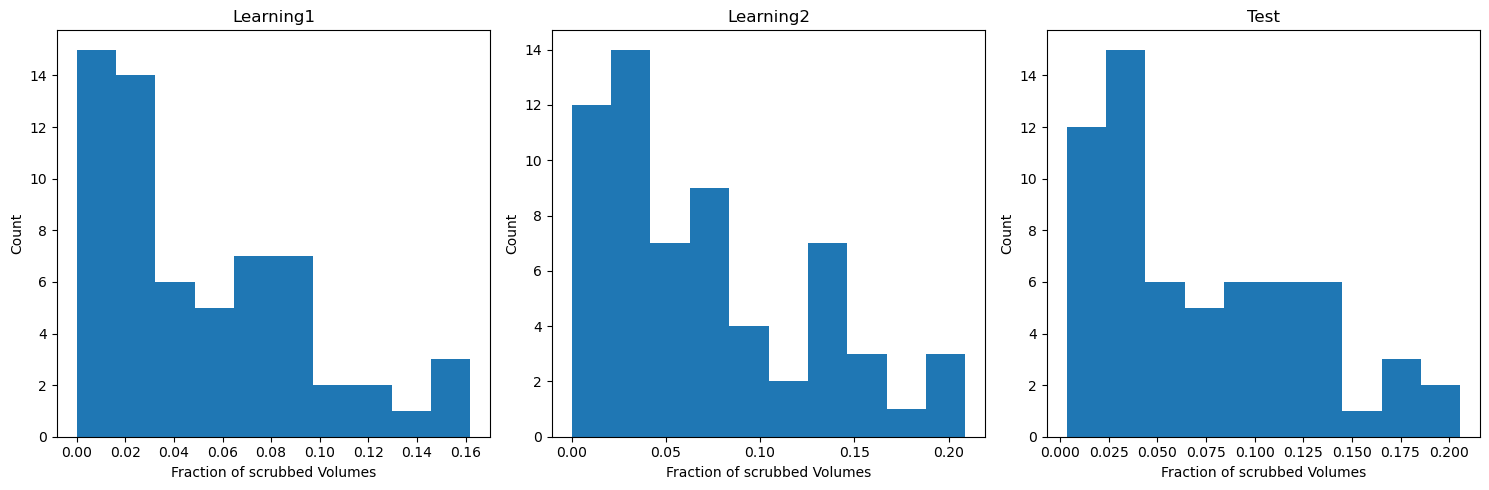

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(scrubbed_volumes[:, 0], bins=10, label='learning1')
axes[0].set_title('Learning1')
axes[0].set_xlabel('Fraction of scrubbed Volumes')
axes[0].set_ylabel('Count')

axes[1].hist(scrubbed_volumes[:, 1], bins=10, label='learning2')
axes[1].set_title('Learning2')
axes[1].set_xlabel('Fraction of scrubbed Volumes')
axes[1].set_ylabel('Count')

axes[2].hist(scrubbed_volumes[:, 2], bins=10, label='test')
axes[2].set_title('Test')
axes[2].set_xlabel('Fraction of scrubbed Volumes')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
# exclusion threshold
max_scrub = 0.25

In [12]:
for run in range(3):
    subject_ids = [sub_ids[i] for i in range(len(sub_ids)) if scrubbed_volumes[i, run] > max_scrub]
    print(f'Run {run}: {len(subject_ids)} subjects with > {max_scrub} scrubbed volumes')
    print(f'Subject IDs: {subject_ids}')


Run 0: 0 subjects with > 0.25 scrubbed volumes
Subject IDs: []
Run 1: 0 subjects with > 0.25 scrubbed volumes
Subject IDs: []
Run 2: 0 subjects with > 0.25 scrubbed volumes
Subject IDs: []
